# Compare NLP Techniques: Build A Basic RNN

### Read In Cleaned Text

In [3]:
# Load the cleaned training and test sets
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

X_train = pd.read_csv('./data/X_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
y_train = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_test.csv')

### Prep Data

In [4]:
# Train the tokenizer and use that tokenizer to convert the sentences to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [6]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

### Build And Evaluate RNN

In [7]:
# Import the tools needed and use our previously defined functions to calculate precision and recall
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [8]:
# Construct our basic RNN model framework
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          263968    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 273,377
Trainable params: 273,377
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [10]:
# Fit the RNN
history = model.fit(X_train_seq_padded, y_train['label'], 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 4s 17ms/step - loss: 0.4210 - accuracy: 0.8662 - precision_m: 0.2017 - recall_m: 0.1525 - val_loss: 0.1006 - val_accuracy: 0.9686 - val_precision_m: 0.9833 - val_recall_m: 0.8113
Epoch 2/10
140/140 [==============================] - 2s 12ms/step - loss: 0.0368 - accuracy: 0.9913 - precision_m: 0.9643 - recall_m: 0.9191 - val_loss: 0.0568 - val_accuracy: 0.9839 - val_precision_m: 0.9871 - val_recall_m: 0.9225
Epoch 3/10
140/140 [==============================] - 2s 12ms/step - loss: 0.0097 - accuracy: 0.9971 - precision_m: 0.9901 - recall_m: 0.9767 - val_loss: 0.0723 - val_accuracy: 0.9803 - val_precision_m: 0.9943 - val_recall_m: 0.8837
Epoch 4/10
140/140 [==============================] - 2s 13ms/step - loss: 0.0069 - accuracy: 0.9976 - precision_m: 0.9942 - recall_m: 0.9909 - val_loss: 0.0900 - val_accuracy: 0.9821 - val_precision_m: 1.0000 - val_recall_m: 0.8932
Epoch 5/10
140/140 [==============================] - 2s 12ms/step -

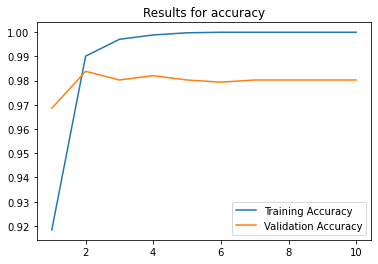

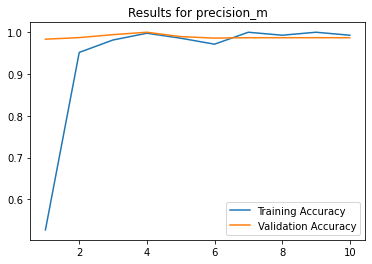

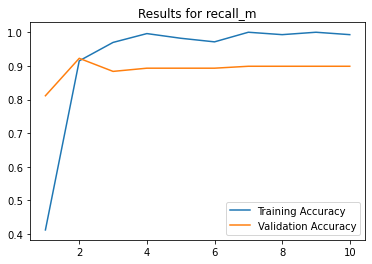

In [11]:
# Plot basic evaluation metrics across epochs
import matplotlib.pyplot as plt
%matplotlib inline

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()